## 딥러닝 모델 -> 학습까지의 순서 정리.
- (1) Function API로 모델 만들기
- (2) 이미지 데이터의 경우 -> 전처리작업 수행
- (3) class 분류의 경우, One hot Encoding 수행
- (4) 학습, 검증 모델 나누기
- (5) Compile, 학습/예측/평가

### (1) Functional API로 모델 만들기

In [3]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Layer, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf


INPUT_SIZE = 28
def create_model():
    clear_session()
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(input_tensor, output)
    return  model

In [4]:
# test
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


- keras에서 None은 batch_size다, Param는 weight + bias가 더해진 값
- 784 * 100 + 100 = 78500

### (2) img데이터의 경우, 전처리 작업 수행
- 0~1 사이의 값의 float32로 변경하는 함수
- (0-255 -> 0-1로 변환)

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# 0 ~ 1사이값의 float32로 변경하는 함수(0~255 -> 0~1로 변환)
def get_preprocessed_data(images, labels):
    images = np.array(images / 255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

# 0~1 사이값으로 변경해주는 함수 호출 뒤 OHE 적용(One-hot-encoding)
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # labels로 ohe수행
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리와 OHE를 적용한 뒤 반환
# 이때, 전처리 작업을 모두 한뒤에 -> split하자.
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2023):

    # 1.전처리 작업을 전부 수행
    trian_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 2.학습데이터로부터 검증데이터 만들기
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

#### 데이터셋 불러오기

In [19]:
from tensorflow.keras.datasets import fashion_mnist
# Fashion MNIST 데이터 로딩 및 전처리 적용하여 학습/검증/데이터 세트 생성
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [20]:
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels,
                             valid_size=0.15, random_state=2023)
print(f'tr_images: ', tr_images.shape)
print(f'tr_oh_labels: ', tr_oh_labels.shape)
print(f'val_images: ', val_images.shape)
print(f'val_oh_labels: ', val_oh_labels.shape)
print(f'test_images: ', test_images.shape)
print(f'test_oh_labels: ', test_oh_labels.shape)

tr_images:  (51000, 28, 28)
tr_oh_labels:  (51000, 10)
val_images:  (9000, 28, 28)
val_oh_labels:  (9000, 10)
test_images:  (10000, 28, 28)
test_oh_labels:  (10000, 10)


#### 모델 생성과 compile

In [21]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용
model = create_model()
model.summary()


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


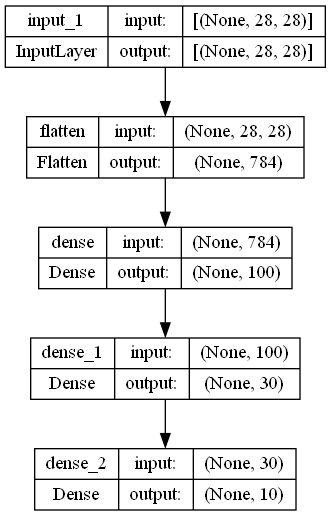

In [22]:
plot_model(model, show_shapes=True)

### 학습 수행
- tr_images: 학습용이미지(60,000 x 28 x 28), tr_oh_labels

In [23]:
# 여기서 batch_size가 만약 32이면 32 x 28 x28 이 메모리에 들어감.(iteration 1회마다)
history = model.fit(x = tr_images, y=tr_oh_labels, batch_size=128, epochs=20,
                    validation_data= (val_images, val_oh_labels))

Epoch 1/20
399/399 [==============================] - 1s 3ms/step - loss: 3.5499 - accuracy: 0.3678 - val_loss: 1.5042 - val_accuracy: 0.4291
Epoch 2/20
399/399 [==============================] - 1s 3ms/step - loss: 1.4227 - accuracy: 0.4394 - val_loss: 1.3558 - val_accuracy: 0.4356
Epoch 3/20
399/399 [==============================] - 1s 2ms/step - loss: 1.3169 - accuracy: 0.4590 - val_loss: 1.2935 - val_accuracy: 0.4612
Epoch 4/20
399/399 [==============================] - 1s 2ms/step - loss: 1.2592 - accuracy: 0.4695 - val_loss: 1.2160 - val_accuracy: 0.4992
Epoch 5/20
399/399 [==============================] - 1s 2ms/step - loss: 1.1494 - accuracy: 0.5270 - val_loss: 1.1027 - val_accuracy: 0.5434
Epoch 6/20
399/399 [==============================] - 1s 2ms/step - loss: 1.0613 - accuracy: 0.5584 - val_loss: 1.0113 - val_accuracy: 0.6110
Epoch 7/20
399/399 [==============================] - 1s 2ms/step - loss: 0.8494 - accuracy: 0.6690 - val_loss: 0.7866 - val_accuracy: 0.7054
Epoch 

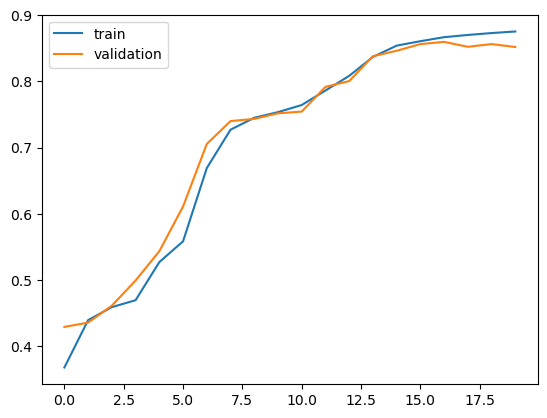

In [24]:
import matplotlib.pyplot as plt

# 그래프 그리기
def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
show_history(history)

In [26]:
# 테스트 데이터 세트로 모델 성능 검출
y_pred = model.evaluate(test_images, test_oh_labels, batch_size=128, verbose=1)
print(f'y_pred: loss값 :', y_pred[0])
print(f'y_pred: accuracy값: ', y_pred[1])

79/79 [==============================] - 0s 4ms/step - loss: 3.9145 - accuracy: 0.1000
y_pred: loss값 : 3.9144980907440186
y_pred: accuracy값:  0.10000000149011612
